В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [44]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [45]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'

In [46]:
od.download(dataset_url)

Skipping, found downloaded files in ".\bank-customer-churn-prediction-dlu" (use force=True to force download)


In [47]:
data_dir = './bank-customer-churn-prediction-dlu'

In [48]:
train_csv = data_dir + '/train.csv'
test_csv = data_dir + '/test.csv'
sample_submission = data_dir + '/sample_submission.csv'

In [49]:
train_df = pd.read_csv(train_csv)

In [50]:
train_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [51]:
train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [52]:
from sklearn.model_selection import train_test_split

<Axes: xlabel='Exited', ylabel='count'>

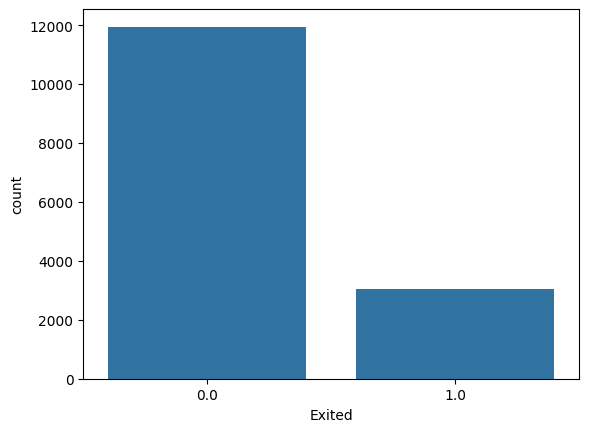

In [53]:
sns.countplot(x = 'Exited', data = train_df)

In [54]:
train_df['Exited'].value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

In [55]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Exited'])

In [56]:
val_df['Exited'].value_counts(normalize=True)

Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64

In [57]:
train_df['Exited'].value_counts(normalize=True)

Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [58]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'

In [59]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [60]:
val_inputs = train_df[input_cols].copy()
val_targets = train_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [61]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = ['Geography', 'Gender']

In [62]:
numeric_cols, categorical_cols

(['CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

<Axes: ylabel='Balance'>

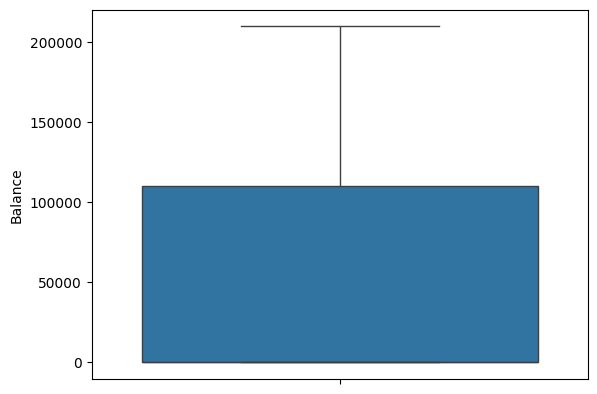

In [63]:
sns.boxplot(train_inputs.Balance)

In [64]:
train_inputs.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.569092e+07,658.840250,37.687917,5.026083,43008.174362,1.590250,0.790333,0.491583,117992.400015
std,1.469310e+05,72.334909,8.138440,2.781974,59906.627660,0.532646,0.407088,0.499950,45589.484607
min,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,1.563512e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83343.730000
50%,1.568995e+07,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123613.910000
75%,1.575692e+07,708.000000,42.000000,7.000000,109949.050000,2.000000,1.000000,1.000000,156912.810000
max,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


In [65]:
train_inputs.Age.max()

74.0

In [66]:
train_inputs.Age.value_counts()

Age
35.0    711
34.0    687
38.0    685
37.0    666
36.0    654
33.0    633
39.0    604
32.0    572
31.0    560
40.0    557
41.0    504
29.0    495
30.0    400
42.0    398
43.0    393
44.0    309
28.0    298
46.0    264
45.0    247
47.0    206
27.0    189
26.0    170
48.0    166
25.0    139
49.0    136
51.0    125
52.0    121
24.0    111
50.0    109
23.0     91
56.0     78
55.0     77
54.0     77
22.0     70
57.0     59
53.0     50
58.0     48
59.0     46
60.0     43
61.0     43
21.0     42
66.0     23
62.0     22
63.0     20
64.0     19
67.0     18
20.0     17
71.0     12
19.0     11
72.0      5
18.0      4
65.0      4
70.0      4
69.0      4
68.0      3
74.0      1
Name: count, dtype: int64

In [67]:
train_inputs['Balance'].value_counts().sort_values(ascending = False)

Balance
0.00         7774
122314.50      13
133658.24      11
127864.40      11
123544.00      10
             ... 
117056.46       1
151739.65       1
121797.09       1
132932.15       1
132005.77       1
Name: count, Length: 2895, dtype: int64

In [68]:
train_inputs['Tenure'].value_counts().sort_values(ascending = False)

Tenure
2.0     1391
5.0     1298
7.0     1265
3.0     1258
8.0     1248
9.0     1240
4.0     1231
6.0     1178
1.0     1166
10.0     411
0.0      314
Name: count, dtype: int64

In [69]:
train_inputs.Geography.unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [70]:
train_inputs[numeric_cols].isna().sum()

CustomerId         0
CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [71]:
numeric_cols = [
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [74]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [75]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [76]:
val_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.54,0.35,0.50,0.21,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [77]:
from sklearn.preprocessing import OneHotEncoder

In [78]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [79]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [80]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [81]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [82]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [83]:
display(train_inputs.head(5))

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,15652218.0,Mays,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,15592937.0,Ch'eng,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,15774586.0,Ch'in,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,15780572.0,K?,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,15642099.0,Trevisani,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


In [84]:
display(val_inputs.head(5))

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,15652218.0,Mays,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,15592937.0,Ch'eng,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,15774586.0,Ch'in,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,15780572.0,K?,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,15642099.0,Trevisani,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


**Спостереження**
В числових коонках я обрала нормалізацію в діапазоні від 0 до 1, щоб привести всі дані в один вигляд. Для категоріальних Колонок я використала OneHotEncoder, т.я. у нас не багато різних регіонів (всього три) то кількість колонок значно не збільшилась. Колонку Surname, я не буду використовувати в навчанні моделі, т.я. вона не впливає на результат, тому я її не кодувала. Також я експерементувала з колонкою Age, перетворювала її в категоріальну зі значеннями 0-20, 30-40 і т.д. але результат від цього не покращився, тому я вирішила залишити колонку вік, як числову.

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [85]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [86]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: total: 0 ns
Wall time: 13 ms


In [87]:
os.listdir('./')

['.ipynb_checkpoints',
 'bank-customer-churn-prediction-dlu',
 'HW_2_7_Логістична_регресія_з_scikit_learn.ipynb',
 'log_reg.joblib',
 'submission_log_reg.csv',
 'submission_log_reg1.csv',
 'submission_log_reg2.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [88]:
X_train = train_inputs[numeric_cols + encoded_cols]

In [89]:
X_val = val_inputs[numeric_cols + encoded_cols]

In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
model = LogisticRegression(solver='liblinear')
#model = LogisticRegression(solver='newton-cholesky')

In [92]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [93]:
train_preds = model.predict(X_train)

In [95]:
val_preds = model.predict(X_val)

In [97]:
from sklearn.metrics import accuracy_score

In [98]:
accuracy_score(train_targets, train_preds)

0.87425

In [99]:
accuracy_score(val_targets, val_preds)

0.87425

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [100]:
from sklearn.metrics import confusion_matrix

In [101]:
confusion_matrix(train_targets, train_preds)

array([[9177,  381],
       [1128, 1314]], dtype=int64)

In [102]:
confusion_matrix(val_targets, val_preds)

array([[9177,  381],
       [1128, 1314]], dtype=int64)

In [103]:
from sklearn.metrics import f1_score

In [104]:
f1_score(train_targets, train_preds)

0.6352429296591733

In [105]:
f1_score(val_targets, val_preds)

0.6352429296591733

In [106]:
from sklearn.metrics import roc_curve, auc

In [107]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


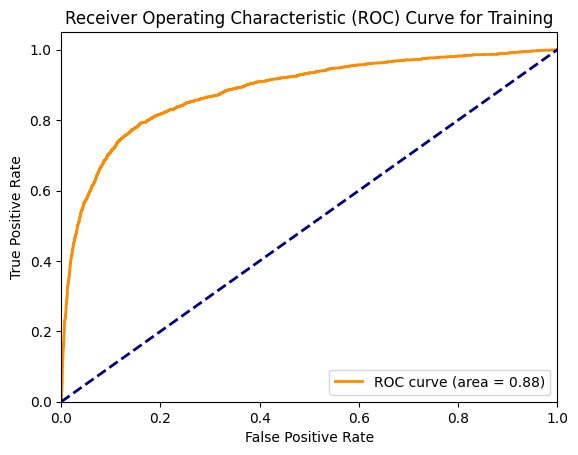

In [108]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')

AUROC for Validation: 0.88


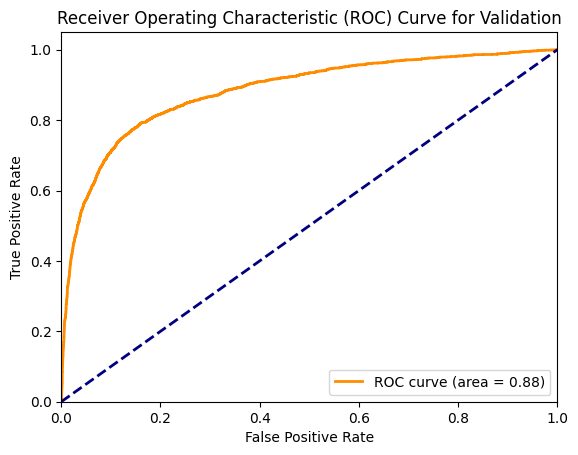

In [109]:
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

**Спостереження**
AUROC for Training: 0.88 - це хороший показник 
По матриці помилок видно, що модель часто помиляється на False Negative (1128 значень), можна оптимізувати цей момент.
F1-score 0.63 вважаю для цієї задачі добрим, т.я. дані не збалансовані.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [110]:
def all_null(inputs):
    return np.full(len(inputs), 0)

In [111]:
accuracy_score(train_targets, all_null(X_train))

0.7965

In [112]:
accuracy_score(val_targets, all_null(X_val))

0.7965

**Спостереження**
Accuracy на нашый реальній моделі вище (0.87425), ніж на можделі, яка передбачає тільки нулі, отже наша модель є задовільною.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [737]:
import joblib

In [738]:
aussie_rain = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [739]:
joblib.dump(aussie_rain, 'log_reg.joblib')

['log_reg.joblib']

In [740]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [741]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [742]:
test_raw_df = pd.read_csv(test_csv)

In [743]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [744]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [745]:
#test_raw_df[encoded_cols] = encoder.transform(test_raw_df[categorical_cols])

In [746]:
#test_raw_df[numeric_cols] = scaler.transform(test_raw_df[numeric_cols])

In [747]:
numeric_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [748]:
test_raw_df[numeric_cols] 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.365155,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477
1,0.286396,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131
2,0.656325,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859
3,0.682578,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571
4,0.384248,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421
...,...,...,...,...,...,...,...,...
9995,0.496420,0.357143,1.0,0.000000,0.333333,1.0,1.0,0.248154
9996,0.589499,0.375000,0.9,0.000000,0.333333,1.0,1.0,0.712578
9997,0.818616,0.214286,0.9,0.000000,0.333333,1.0,0.0,0.024253
9998,0.391408,0.357143,0.6,0.690650,0.000000,1.0,0.0,0.632348


In [749]:
test_raw_df[numeric_cols]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.365155,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477
1,0.286396,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131
2,0.656325,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859
3,0.682578,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571
4,0.384248,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421
...,...,...,...,...,...,...,...,...
9995,0.496420,0.357143,1.0,0.000000,0.333333,1.0,1.0,0.248154
9996,0.589499,0.375000,0.9,0.000000,0.333333,1.0,1.0,0.712578
9997,0.818616,0.214286,0.9,0.000000,0.333333,1.0,0.0,0.024253
9998,0.391408,0.357143,0.6,0.690650,0.000000,1.0,0.0,0.632348


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [750]:
sample_submission = pd.read_csv(sample_submission)

In [751]:
sample_submission

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5


In [752]:
merged_df = sample_submission.merge(test_raw_df, on='id', how='left')

In [561]:
merged_df

,id,Exited_x,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited_y
0,15000,0.5,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0,1.0,0.0,0.0,1.0,0.0
1,15001,0.5,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,1.0,0.0,0.0,0.0,1.0,1.0
2,15002,0.5,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,1.0,0.0,0.0,0.0,1.0,1.0
3,15003,0.5,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0,0.0,1.0,0.0,1.0,1.0
4,15004,0.5,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,0.5,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65,0.0,0.0,1.0,0.0,1.0,1.0
9996,24996,0.5,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50,0.0,0.0,1.0,0.0,1.0,1.0
9997,24997,0.5,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72,1.0,0.0,0.0,0.0,1.0,1.0
9998,24998,0.5,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09,1.0,0.0,0.0,0.0,1.0,0.0


In [753]:
merged_df['Exited'] = merged_df['Exited_y']

In [652]:
merged_df

,id,Exited_x,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,...,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited_y,Exited
0,15000,0.5,15594796.0,Chu,-1.027768,Germany,Male,-0.317602,0.02,0.000003,...,1.0,1.0,-0.000054,0.0,1.0,0.0,0.0,1.0,0.075316,0.075316
1,15001,0.5,15642821.0,Mazzi,-1.027956,France,Male,-0.314732,0.05,0.000000,...,1.0,1.0,-0.000056,1.0,0.0,0.0,0.0,1.0,0.035366,0.035366
2,15002,0.5,15716284.0,Onyekachi,-1.027073,France,Male,-0.313457,0.08,0.000000,...,1.0,0.0,-0.000054,1.0,0.0,0.0,0.0,1.0,0.153210,0.153210
3,15003,0.5,15785078.0,Martin,-1.027011,Spain,Male,-0.312819,0.03,0.000000,...,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.194872,0.194872
4,15004,0.5,15662955.0,Kenechukwu,-1.027723,Spain,Male,-0.313457,0.08,0.000000,...,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.055660,0.055660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,0.5,15642997.0,Chukwumaobim,-1.027455,Spain,Male,-0.315051,0.10,0.000000,...,1.0,1.0,-0.000057,0.0,0.0,1.0,0.0,1.0,0.022145,0.022145
9996,24996,0.5,15739271.0,Clements,-1.027233,Spain,Male,-0.314732,0.09,0.000000,...,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.026017,0.026017
9997,24997,0.5,15756743.0,Chidiebere,-1.026686,France,Male,-0.317602,0.09,0.000000,...,1.0,0.0,-0.000058,1.0,0.0,0.0,0.0,1.0,0.018623,0.018623
9998,24998,0.5,15680167.0,Yermakova,-1.027705,France,Male,-0.315051,0.06,0.000003,...,1.0,0.0,-0.000055,1.0,0.0,0.0,0.0,1.0,0.155567,0.155567


In [754]:
merged_df = merged_df[['id', 'Exited']]

In [654]:
merged_df

,id,Exited
0,15000,0.075316
1,15001,0.035366
2,15002,0.153210
3,15003,0.194872
4,15004,0.055660
...,...,...
9995,24995,0.022145
9996,24996,0.026017
9997,24997,0.018623
9998,24998,0.155567


In [755]:
merged_df.to_csv('submission_log_reg2.csv', index=False)

In [657]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.0,Chu,-1.027768,Germany,Male,-0.317602,0.02,0.000003,-0.333333,1.0,1.0,-0.000054,0.0,1.0,0.0,0.0,1.0,0.075316
1,15001,15642821.0,Mazzi,-1.027956,France,Male,-0.314732,0.05,0.000000,-0.222222,1.0,1.0,-0.000056,1.0,0.0,0.0,0.0,1.0,0.035366
2,15002,15716284.0,Onyekachi,-1.027073,France,Male,-0.313457,0.08,0.000000,-0.222222,1.0,0.0,-0.000054,1.0,0.0,0.0,0.0,1.0,0.153210
3,15003,15785078.0,Martin,-1.027011,Spain,Male,-0.312819,0.03,0.000000,-0.333333,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.194872
4,15004,15662955.0,Kenechukwu,-1.027723,Spain,Male,-0.313457,0.08,0.000000,-0.222222,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.055660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,-1.027455,Spain,Male,-0.315051,0.10,0.000000,-0.222222,1.0,1.0,-0.000057,0.0,0.0,1.0,0.0,1.0,0.022145
9996,24996,15739271.0,Clements,-1.027233,Spain,Male,-0.314732,0.09,0.000000,-0.222222,1.0,1.0,-0.000054,0.0,0.0,1.0,0.0,1.0,0.026017
9997,24997,15756743.0,Chidiebere,-1.026686,France,Male,-0.317602,0.09,0.000000,-0.222222,1.0,0.0,-0.000058,1.0,0.0,0.0,0.0,1.0,0.018623
9998,24998,15680167.0,Yermakova,-1.027705,France,Male,-0.315051,0.06,0.000003,-0.333333,1.0,0.0,-0.000055,1.0,0.0,0.0,0.0,1.0,0.155567
